# Multi-class Segmentation Evaluation for Archaeological Masonry

This notebook evaluates multi-class segmentation masks using IoU and F1 scores.

## RGB Color Mapping:
- Black (0,0,0) → Background (Class 0)
- Blue (0,0,255) → Ashlar (Class 1)
- Red (255,0,0) → Polygonal (Class 2)
- Yellow (255,255,0) → Quarry Stone (Class 3)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

In [38]:
Image.MAX_IMAGE_PIXELS = None

In [39]:
class SegmentationEvaluator:
    """
    Evaluator for multi-class segmentation masks in archaeological masonry analysis.
    """
    
    def __init__(self, class_names: List[str] = None, class_colors: List[str] = None):
        """
        Initialize the evaluator with class names and colors.
        
        Args:
            class_names: List of class names (e.g., ['Background', 'Ashlar', 'Polygonal', 'Quarry Stone'])
            class_colors: List of colors for visualization
        """
        if class_names is None:
            # Default class names for masonry segmentation
            self.class_names = ['Background', 'Ashlar', 'Polygonal', 'Quarry Stone']
        else:
            self.class_names = class_names
            
        self.num_classes = len(self.class_names)
        
        if class_colors is None:
            # Default color scheme matching your RGB values
            self.class_colors = ['#000000', '#0000FF', '#FF0000', '#FFFF00']  # Black, Blue, Red, Yellow
        else:
            self.class_colors = class_colors
            
        # RGB color mapping for your specific format
        self.rgb_to_class = {
            (0, 0, 0): 0,       # Black -> Background
            (0, 0, 255): 1,     # Blue -> Ashlar
            (255, 0, 0): 2,     # Red -> Polygonal
            (255, 255, 0): 3    # Yellow -> Quarry Stone
        }
        
        # Create reverse mapping for visualization
        self.class_to_rgb = {v: k for k, v in self.rgb_to_class.items()}
    
    def load_masks(self, gt_path: str, pred_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Load ground truth and predicted masks from file paths.
        Converts RGB color-coded masks to class indices.
        
        Args:
            gt_path: Path to ground truth mask
            pred_path: Path to predicted mask
            
        Returns:
            Tuple of (ground_truth_mask, predicted_mask) as numpy arrays with class indices
        """
        # Load images
        gt_img = Image.open(gt_path).convert('RGB')
        pred_img = Image.open(pred_path).convert('RGB')
        
        gt_rgb = np.array(gt_img)
        pred_rgb = np.array(pred_img)
        
        # Ensure masks have same shape
        assert gt_rgb.shape[:2] == pred_rgb.shape[:2], f"Mask shapes don't match: {gt_rgb.shape} vs {pred_rgb.shape}"
        
        # Convert RGB to class indices
        gt_mask = self.rgb_to_class_indices(gt_rgb)
        pred_mask = self.rgb_to_class_indices(pred_rgb)
        
        # Validate class values
        unique_gt = np.unique(gt_mask)
        unique_pred = np.unique(pred_mask)
        
        print(f"Ground truth classes: {unique_gt}")
        print(f"Predicted classes: {unique_pred}")
        print(f"Mask shape: {gt_mask.shape}")
        
        # Print class distribution
        print("\nClass distribution in ground truth:")
        for class_idx in unique_gt:
            if class_idx < len(self.class_names):
                count = np.sum(gt_mask == class_idx)
                percentage = (count / gt_mask.size) * 100
                print(f"  {self.class_names[class_idx]}: {count} pixels ({percentage:.2f}%)")
        
        return gt_mask, pred_mask
    
    def rgb_to_class_indices(self, rgb_mask: np.ndarray) -> np.ndarray:
        """
        Convert RGB mask to class indices based on color mapping.
        
        Args:
            rgb_mask: RGB image array (H, W, 3)
            
        Returns:
            Class index array (H, W)
        """
        height, width = rgb_mask.shape[:2]
        class_mask = np.zeros((height, width), dtype=np.uint8)
        
        # Convert each RGB color to its corresponding class
        for rgb_tuple, class_idx in self.rgb_to_class.items():
            # Create mask for pixels matching this RGB value
            color_mask = np.all(rgb_mask == rgb_tuple, axis=2)
            class_mask[color_mask] = class_idx
        
        # Check for unmapped colors (e.g., from anti-aliasing or compression artifacts)
        mapped_pixels = np.zeros((height, width), dtype=bool)
        for rgb_tuple in self.rgb_to_class.keys():
            color_mask = np.all(rgb_mask == rgb_tuple, axis=2)
            mapped_pixels |= color_mask
        
        unmapped_count = np.sum(~mapped_pixels)
        if unmapped_count > 0:
            print(f"\nWarning: {unmapped_count} pixels have unmapped colors!")
            print("This might be due to anti-aliasing or compression artifacts.")
            
            # Try to map unmapped pixels to nearest class
            unmapped_indices = np.where(~mapped_pixels)
            for i in range(len(unmapped_indices[0])):
                y, x = unmapped_indices[0][i], unmapped_indices[1][i]
                pixel_rgb = rgb_mask[y, x]
                
                # Find nearest color by Euclidean distance
                min_dist = float('inf')
                nearest_class = 0
                
                for rgb_tuple, class_idx in self.rgb_to_class.items():
                    dist = np.sqrt(np.sum((pixel_rgb.astype(float) - np.array(rgb_tuple).astype(float))**2))
                    if dist < min_dist:
                        min_dist = dist
                        nearest_class = class_idx
                
                class_mask[y, x] = nearest_class
            
            print(f"Mapped unmapped pixels to nearest color classes.")
            
            # Show unique unmapped colors for debugging
            unmapped_pixels = rgb_mask[unmapped_indices]
            unique_unmapped = np.unique(unmapped_pixels, axis=0)
            if len(unique_unmapped) <= 10:
                print("\nUnmapped RGB values found:")
                for color in unique_unmapped:
                    print(f"  RGB{tuple(color)}")
            else:
                print(f"\nFound {len(unique_unmapped)} unique unmapped colors (showing first 10):")
                for color in unique_unmapped[:10]:
                    print(f"  RGB{tuple(color)}")
        
        return class_mask
    
    def calculate_iou_per_class(self, gt_mask: np.ndarray, pred_mask: np.ndarray) -> Dict[str, float]:
        """
        Calculate Intersection over Union (IoU) for each class.
        
        Args:
            gt_mask: Ground truth mask
            pred_mask: Predicted mask
            
        Returns:
            Dictionary mapping class names to IoU scores
        """
        iou_scores = {}
        
        for class_idx in range(self.num_classes):
            # Create binary masks for current class
            gt_binary = (gt_mask == class_idx).astype(np.uint8)
            pred_binary = (pred_mask == class_idx).astype(np.uint8)
            
            # Calculate intersection and union
            intersection = np.logical_and(gt_binary, pred_binary).sum()
            union = np.logical_or(gt_binary, pred_binary).sum()
            
            # Calculate IoU (handle division by zero)
            if union == 0:
                iou = 0.0 if intersection == 0 else 1.0
            else:
                iou = intersection / union
            
            iou_scores[self.class_names[class_idx]] = iou
        
        return iou_scores
    
    def calculate_mean_iou(self, iou_scores: Dict[str, float], ignore_background: bool = True) -> float:
        """
        Calculate mean IoU across all classes.
        
        Args:
            iou_scores: Dictionary of per-class IoU scores
            ignore_background: Whether to exclude background class from mean calculation
            
        Returns:
            Mean IoU score
        """
        if ignore_background and 'Background' in iou_scores:
            # Calculate mean excluding background
            relevant_scores = [score for name, score in iou_scores.items() if name != 'Background']
        else:
            relevant_scores = list(iou_scores.values())
        
        return np.mean(relevant_scores) if relevant_scores else 0.0
    
    def calculate_f1_scores(self, gt_mask: np.ndarray, pred_mask: np.ndarray) -> Dict[str, Dict[str, float]]:
        """
        Calculate F1 scores (per-class and macro) for segmentation.
        
        Args:
            gt_mask: Ground truth mask
            pred_mask: Predicted mask
            
        Returns:
            Dictionary containing per-class F1 scores and macro F1
        """
        # Flatten masks for sklearn metrics
        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()
        
        # Get classification report
        report = classification_report(
            gt_flat, 
            pred_flat, 
            labels=list(range(self.num_classes)),
            target_names=self.class_names,
            output_dict=True,
            zero_division=0
        )
        
        # Extract F1 scores
        f1_scores = {}
        for class_name in self.class_names:
            if class_name in report:
                f1_scores[class_name] = {
                    'precision': report[class_name]['precision'],
                    'recall': report[class_name]['recall'],
                    'f1-score': report[class_name]['f1-score'],
                    'support': report[class_name]['support']
                }
        
        # Add macro and weighted averages
        f1_scores['macro_avg'] = report['macro avg']['f1-score']
        f1_scores['weighted_avg'] = report['weighted avg']['f1-score']
        
        return f1_scores
    
    def calculate_confusion_matrix(self, gt_mask: np.ndarray, pred_mask: np.ndarray) -> np.ndarray:
        """
        Calculate confusion matrix for segmentation.
        
        Args:
            gt_mask: Ground truth mask
            pred_mask: Predicted mask
            
        Returns:
            Confusion matrix
        """
        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()
        
        return confusion_matrix(gt_flat, pred_flat, labels=list(range(self.num_classes)))
    
    def visualize_masks(self, gt_mask: np.ndarray, pred_mask: np.ndarray, 
                       iou_scores: Dict[str, float], save_path: str = None):
        """
        Visualize ground truth and predicted masks side by side with IoU scores.
        
        Args:
            gt_mask: Ground truth mask
            pred_mask: Predicted mask
            iou_scores: Dictionary of IoU scores per class
            save_path: Optional path to save the figure
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Create custom colormap matching the RGB scheme
        cmap = ListedColormap(self.class_colors[:self.num_classes])
        
        # Plot ground truth
        im1 = axes[0, 0].imshow(gt_mask, cmap=cmap, vmin=0, vmax=self.num_classes-1)
        axes[0, 0].set_title('Ground Truth Mask', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Plot prediction
        im2 = axes[0, 1].imshow(pred_mask, cmap=cmap, vmin=0, vmax=self.num_classes-1)
        axes[0, 1].set_title('Predicted Mask', fontsize=14, fontweight='bold')
        axes[0, 1].axis('off')
        
        # Create colorbar with proper labels
        cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.35])
        cbar = plt.colorbar(im1, cax=cbar_ax)
        cbar.set_ticks(np.arange(self.num_classes))
        cbar.set_ticklabels(self.class_names)
        cbar.ax.tick_params(labelsize=10)
        
        # Plot difference map
        diff_mask = (gt_mask != pred_mask).astype(np.uint8)
        axes[1, 0].imshow(diff_mask, cmap='RdYlBu_r', vmin=0, vmax=1)
        axes[1, 0].set_title('Difference Map (Red = Mismatch)', fontsize=14, fontweight='bold')
        axes[1, 0].axis('off')
        
        # Add colorbar for difference map
        diff_pixels = np.sum(diff_mask)
        total_pixels = diff_mask.size
        error_rate = (diff_pixels / total_pixels) * 100
        axes[1, 0].text(0.5, -0.1, f'Error Rate: {error_rate:.2f}% ({diff_pixels:,} pixels)', 
                       transform=axes[1, 0].transAxes, ha='center', fontsize=10)
        
        # Plot IoU scores as bar chart with matching colors
        classes = list(iou_scores.keys())
        scores = list(iou_scores.values())
        
        # Use the actual colors for each class
        bar_colors = []
        for class_name in classes:
            if class_name in self.class_names:
                idx = self.class_names.index(class_name)
                bar_colors.append(self.class_colors[idx])
            else:
                bar_colors.append('#808080')  # Gray for unknown classes
        
        bars = axes[1, 1].bar(classes, scores, color=bar_colors, edgecolor='black', linewidth=1.5)
        axes[1, 1].set_ylabel('IoU Score', fontsize=12)
        axes[1, 1].set_title('IoU Scores by Class', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylim(0, 1.1)
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                          f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Rotate x-axis labels
        plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def plot_confusion_matrix(self, cm: np.ndarray, save_path: str = None):
        """
        Plot confusion matrix as heatmap.
        
        Args:
            cm: Confusion matrix
            save_path: Optional path to save the figure
        """
        plt.figure(figsize=(10, 8))
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0
        
        # Create heatmap
        sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names,
                   cbar_kws={'label': 'Normalized Count'})
        
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def generate_report(self, gt_mask: np.ndarray, pred_mask: np.ndarray) -> pd.DataFrame:
        """
        Generate a comprehensive evaluation report.
        
        Args:
            gt_mask: Ground truth mask
            pred_mask: Predicted mask
            
        Returns:
            DataFrame with evaluation metrics
        """
        # Calculate all metrics
        iou_scores = self.calculate_iou_per_class(gt_mask, pred_mask)
        mean_iou = self.calculate_mean_iou(iou_scores, ignore_background=True)
        mean_iou_all = self.calculate_mean_iou(iou_scores, ignore_background=False)
        f1_scores = self.calculate_f1_scores(gt_mask, pred_mask)
        
        # Create report dataframe
        report_data = []
        
        for class_name in self.class_names:
            row = {
                'Class': class_name,
                'IoU': iou_scores.get(class_name, 0.0),
                'Precision': f1_scores.get(class_name, {}).get('precision', 0.0),
                'Recall': f1_scores.get(class_name, {}).get('recall', 0.0),
                'F1-Score': f1_scores.get(class_name, {}).get('f1-score', 0.0),
                'Support': f1_scores.get(class_name, {}).get('support', 0)
            }
            report_data.append(row)
        
        df = pd.DataFrame(report_data)
        
        # Add summary statistics
        summary_df = pd.DataFrame([
            {
                'Class': 'Mean (excl. background)',
                'IoU': mean_iou,
                'Precision': '-',
                'Recall': '-',
                'F1-Score': f1_scores['macro_avg'],
                'Support': '-'
            },
            {
                'Class': 'Mean (all classes)',
                'IoU': mean_iou_all,
                'Precision': '-',
                'Recall': '-',
                'F1-Score': f1_scores['weighted_avg'],
                'Support': '-'
            }
        ])
        
        df = pd.concat([df, summary_df], ignore_index=True)
        
        return df

In [40]:
# Example usage
def evaluate_segmentation(gt_path: str, pred_path: str, 
                         class_names: List[str] = None,
                         save_visualizations: bool = True,
                         output_dir: str = './evaluation_results/',
                         show_rgb_preview: bool = True):
    """
    Main function to evaluate segmentation masks.
    
    This function handles RGB masks with the following color mapping:
    - Black (0,0,0)     -> Background (Class 0)
    - Blue (0,0,255)    -> Ashlar (Class 1)
    - Red (255,0,0)     -> Polygonal (Class 2)
    - Yellow (255,255,0) -> Quarry Stone (Class 3)
    
    The function automatically converts RGB colors to class indices and handles
    edge cases like anti-aliasing or compression artifacts by mapping unmapped
    pixels to the nearest valid color class.
    
    Args:
        gt_path: Path to ground truth RGB mask (PNG format)
        pred_path: Path to predicted RGB mask (PNG format)
        class_names: Optional list of class names
        save_visualizations: Whether to save visualization figures
        output_dir: Directory to save outputs
        show_rgb_preview: Whether to show the original RGB masks
    """
    # Create evaluator
    evaluator = SegmentationEvaluator(class_names=class_names)
    
    # Show RGB preview if requested
    if show_rgb_preview:
        print("Loading RGB masks for preview...")
        gt_rgb = np.array(Image.open(gt_path).convert('RGB'))
        pred_rgb = np.array(Image.open(pred_path).convert('RGB'))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.imshow(gt_rgb)
        ax1.set_title('Ground Truth RGB Mask', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        ax2.imshow(pred_rgb)
        ax2.set_title('Predicted RGB Mask', fontsize=14, fontweight='bold')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Load masks
    print("\nLoading and converting RGB masks to class indices...")
    gt_mask, pred_mask = evaluator.load_masks(gt_path, pred_path)
    
    # Calculate metrics
    print("\nCalculating metrics...")
    iou_scores = evaluator.calculate_iou_per_class(gt_mask, pred_mask)
    mean_iou = evaluator.calculate_mean_iou(iou_scores, ignore_background=True)
    mean_iou_all = evaluator.calculate_mean_iou(iou_scores, ignore_background=False)
    f1_scores = evaluator.calculate_f1_scores(gt_mask, pred_mask)
    cm = evaluator.calculate_confusion_matrix(gt_mask, pred_mask)
    
    # Print results
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    
    print("\nPer-Class IoU Scores:")
    print("-"*30)
    for class_name, iou in iou_scores.items():
        print(f"{class_name:20s}: {iou:.4f}")
    
    print(f"\nMean IoU (excluding background): {mean_iou:.4f}")
    print(f"Mean IoU (all classes): {mean_iou_all:.4f}")
    
    print("\n\nPer-Class F1 Scores:")
    print("-"*30)
    for class_name in evaluator.class_names:
        if class_name in f1_scores:
            metrics = f1_scores[class_name]
            print(f"\n{class_name}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1-Score:  {metrics['f1-score']:.4f}")
            print(f"  Support:   {metrics['support']}")
    
    print(f"\n\nMacro F1-Score: {f1_scores['macro_avg']:.4f}")
    print(f"Weighted F1-Score: {f1_scores['weighted_avg']:.4f}")
    
    # Generate report
    report_df = evaluator.generate_report(gt_mask, pred_mask)
    print("\n\nSummary Report:")
    print("-"*60)
    print(report_df.to_string(index=False))
    
    # Visualizations
    if save_visualizations:
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # Mask comparison
        evaluator.visualize_masks(
            gt_mask, pred_mask, iou_scores,
            save_path=os.path.join(output_dir, 'mask_comparison.png')
        )
        
        # Confusion matrix
        evaluator.plot_confusion_matrix(
            cm,
            save_path=os.path.join(output_dir, 'confusion_matrix.png')
        )
        
        # Save report as CSV
        report_df.to_csv(os.path.join(output_dir, 'evaluation_report.csv'), index=False)
        print(f"\n\nResults saved to: {output_dir}")
    
    return report_df, iou_scores, f1_scores, cm

## Main Execution

Update the paths below to point to your RGB PNG masks and run the evaluation.

Loading RGB masks for preview...


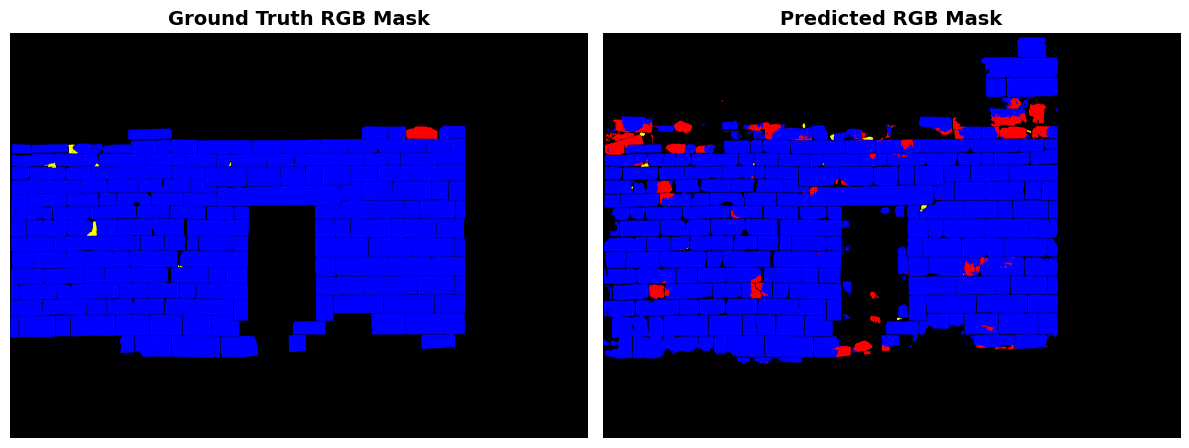


Loading and converting RGB masks to class indices...
Ground truth classes: [0 1 2 3]
Predicted classes: [0 1 2 3]
Mask shape: (7880, 11225)

Class distribution in ground truth:
  Background: 57914392 pixels (65.47%)
  Ashlar: 30351119 pixels (34.31%)
  Polygonal: 125846 pixels (0.14%)
  Quarry Stone: 61643 pixels (0.07%)

Calculating metrics...

EVALUATION RESULTS

Per-Class IoU Scores:
------------------------------
Background          : 0.8983
Ashlar              : 0.8244
Polygonal           : 0.0637
Quarry Stone        : 0.0745

Mean IoU (excluding background): 0.3209
Mean IoU (all classes): 0.4652


Per-Class F1 Scores:
------------------------------

Background:
  Precision: 0.9715
  Recall:    0.9226
  F1-Score:  0.9464
  Support:   57914392.0

Ashlar:
  Precision: 0.8837
  Recall:    0.9248
  F1-Score:  0.9037
  Support:   30351119.0

Polygonal:
  Precision: 0.0645
  Recall:    0.8435
  F1-Score:  0.1199
  Support:   125846.0

Quarry Stone:
  Precision: 0.1591
  Recall:    0.12

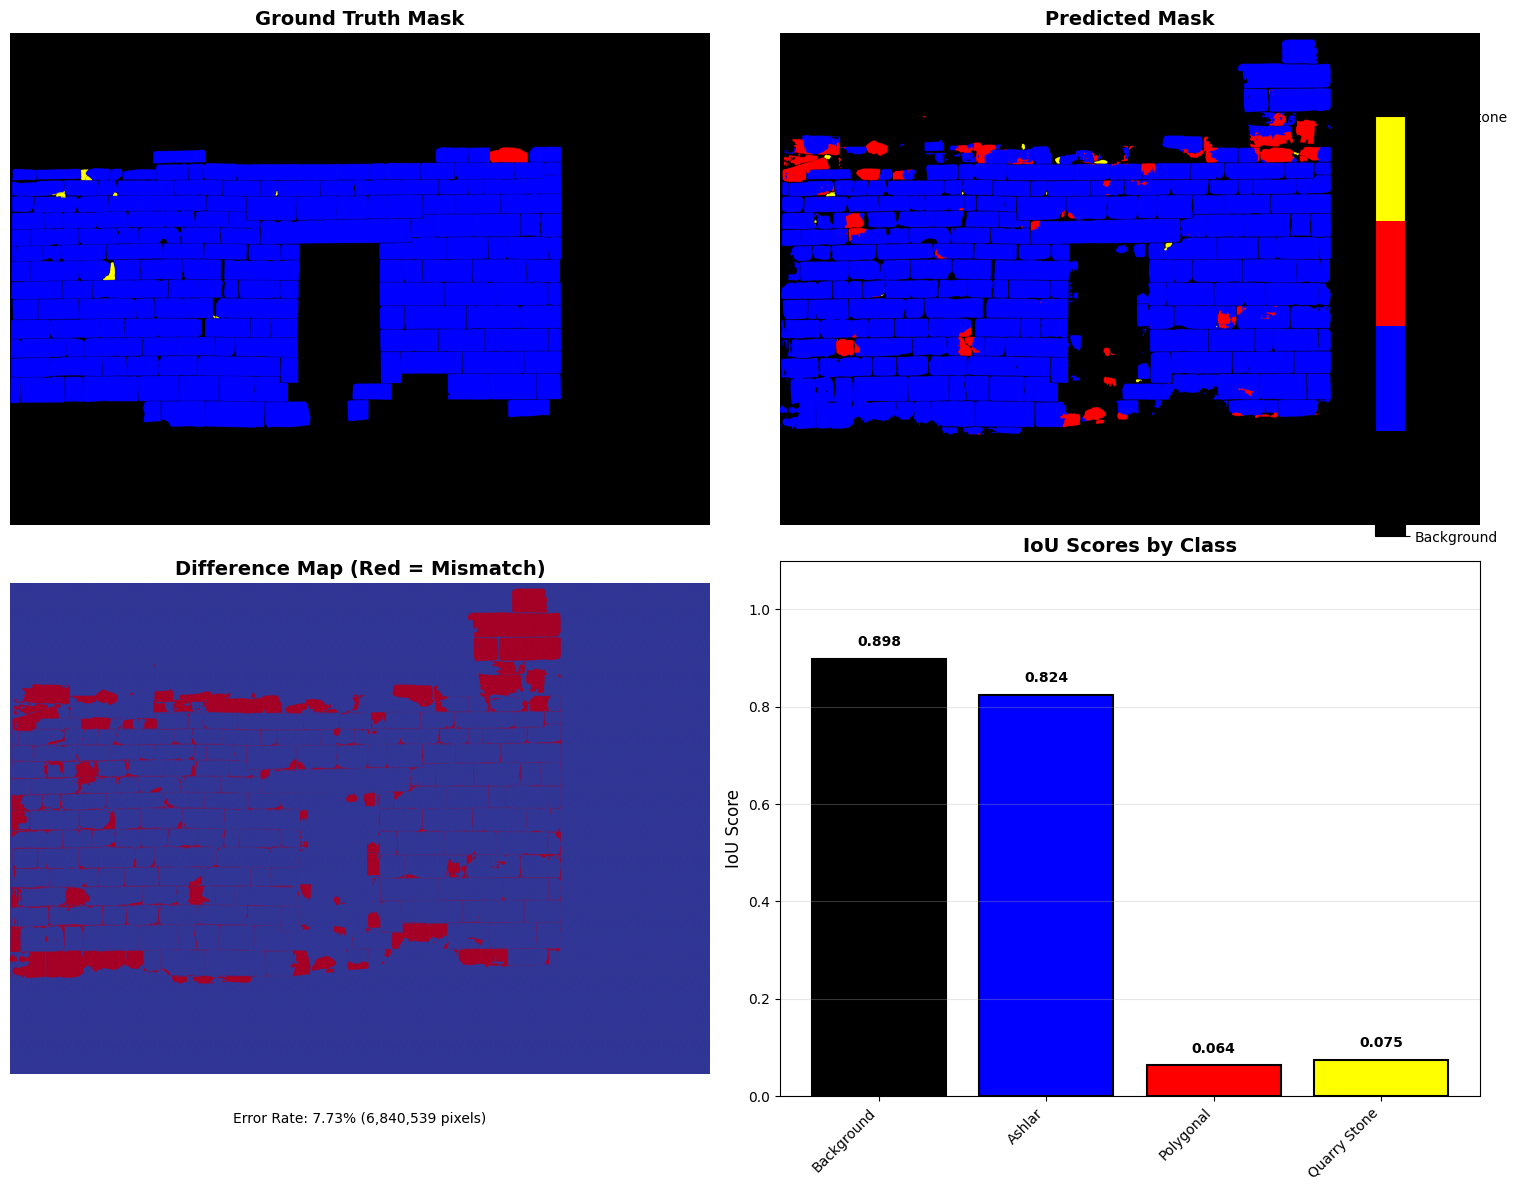

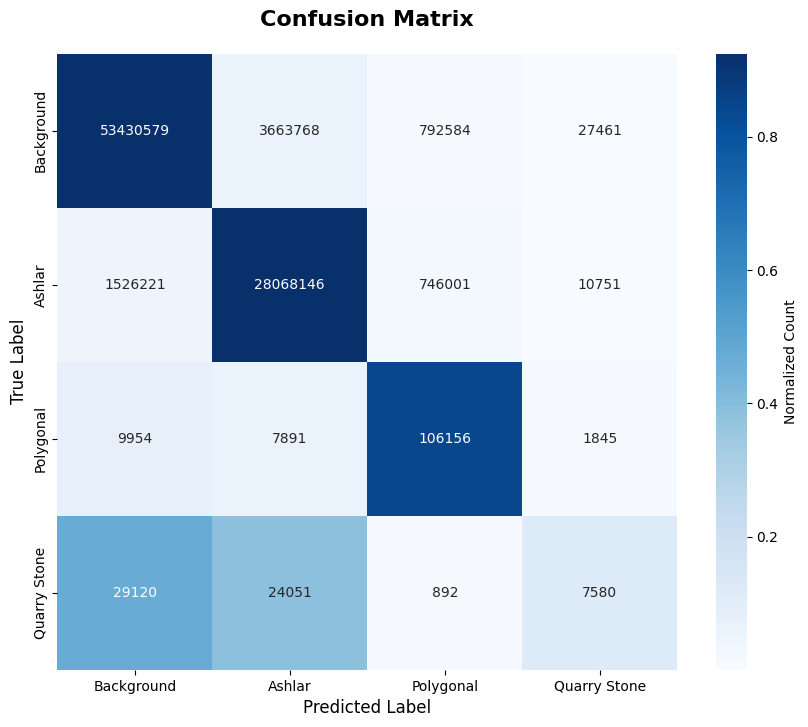



Results saved to: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/06_evaluation


NameError: name 'gt_rgb' is not defined

In [41]:
# ============================================================
# MAIN EXECUTION CELL
# ============================================================

# Define your paths here
GT_MASK_PATH ="C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/02_masks/Kaunos_Isodom_png-ortho.png"  # Update this path
PRED_MASK_PATH = "C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/Kaunos_Isodom_png-ortho_RAW_combined.png"   # Update this path

# Define your class names (matching your color scheme)
CLASS_NAMES = ['Background', 'Ashlar', 'Polygonal', 'Quarry Stone']

# Run evaluation
if __name__ == "__main__":
    # ==== QUICK START: Update these paths and run! ====
    results = evaluate_segmentation(
        gt_path="C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/02_masks/Kaunos_Isodom_png-ortho.png",
        pred_path="C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/Kaunos_Isodom_png-ortho_RAW_combined.png",
        class_names=CLASS_NAMES,
        save_visualizations=True,
        output_dir="C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/06_evaluation",
        show_rgb_preview=True  # Shows original RGB masks before conversion
)
    
    # Save temporary RGB images for demonstration
    from PIL import Image
    import tempfile
    import os
    
    with tempfile.TemporaryDirectory() as temp_dir:
        gt_path_temp = os.path.join(temp_dir, 'gt_rgb.png')
        pred_path_temp = os.path.join(temp_dir, 'pred_rgb.png')
        
        Image.fromarray(gt_rgb).save(gt_path_temp)
        Image.fromarray(pred_rgb).save(pred_path_temp)
        
        # Create evaluator
        evaluator = SegmentationEvaluator(class_names=CLASS_NAMES)
        
        # Load and convert RGB masks
        print("Loading RGB masks and converting to class indices...")
        gt_mask, pred_mask = evaluator.load_masks(gt_path_temp, pred_path_temp)
        
        # Calculate and display metrics
        iou_scores = evaluator.calculate_iou_per_class(gt_mask, pred_mask)
        mean_iou = evaluator.calculate_mean_iou(iou_scores, ignore_background=True)
        f1_scores = evaluator.calculate_f1_scores(gt_mask, pred_mask)
        cm = evaluator.calculate_confusion_matrix(gt_mask, pred_mask)
        
        # Generate visualizations
        evaluator.visualize_masks(gt_mask, pred_mask, iou_scores)
        evaluator.plot_confusion_matrix(cm)
        
        # Generate report
        report = evaluator.generate_report(gt_mask, pred_mask)
        print("/nExample Evaluation Report:")
        print(report.to_string(index=False))
    
    print("/n" + "="*60)
    print("RGB COLOR MAPPING:")
    print("="*60)
    print("Black (0,0,0)     -> Background (Class 0)")
    print("Blue (0,0,255)    -> Ashlar (Class 1)")
    print("Red (255,0,0)     -> Polygonal (Class 2)")
    print("Yellow (255,255,0) -> Quarry Stone (Class 3)")
    print("="*60)